# Imports

In [1]:
import os

import datetime

from typing import Union

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [2]:
import sklearn
from sklearn import set_config

In [3]:
print(f"scikit-learn version is {sklearn.__version__}")

scikit-learn version is 1.2.0


In [4]:
if sklearn.__version__ not in ["1.2.0", "1.2.2"]:
    os.system("pip install scikit-learn==1.2.0")

# Global Configuration

In [5]:
set_config(transform_output="pandas")

In [6]:
KAGGLE = False
CWD = os.getcwd()

In [8]:
print(CWD)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml


In [18]:
if not KAGGLE:
    PATH_INPUT = os.path.join(CWD, "input")
    PATH_INPUT_TRAIN = os.path.join(PATH_INPUT, "train.csv")
    PATH_INPUT_TEST = os.path.join(PATH_INPUT, "test.csv")
    
    print(os.listdir(PATH_INPUT))
    
else:
    PATH_INPUT_TRAIN = "/kaggle/input/spaceship-titanic/train.csv"
    PATH_INPUT_TEST = "/kaggle/input/spaceship-titanic/test.csv"

['test.csv', 'spaceship-titanic.zip', 'train.csv', 'sample_submission.csv']


In [19]:
os.listdir(CWD)

['.DS_Store',
 'requirements.txt',
 'Benchmark_20240328.ipynb',
 'Benchmark_20240331.ipynb',
 'input',
 'venvs',
 'Benchmark_20240329.ipynb',
 'Benchmark_20240330.ipynb',
 'videos',
 '.ipynb_checkpoints',
 'outputs']

# Helper functions

In [20]:
def load_data():
    
    X_train = pd.read_csv(PATH_INPUT_TRAIN).set_index("PassengerId")
    X_test = pd.read_csv(PATH_INPUT_TEST).set_index("PassengerId")
    
    return X_train, X_test

# Dataset loading & EDA

In [21]:
X, _ = load_data()

In [22]:
nulls_per_row = X.isnull()

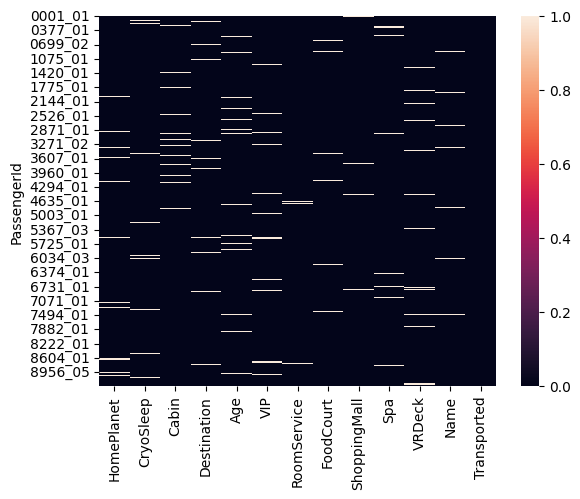

In [23]:
sns.heatmap(nulls_per_row);

In [24]:
(X.isnull().sum(axis = 1) == X.shape[1]).sum()

0

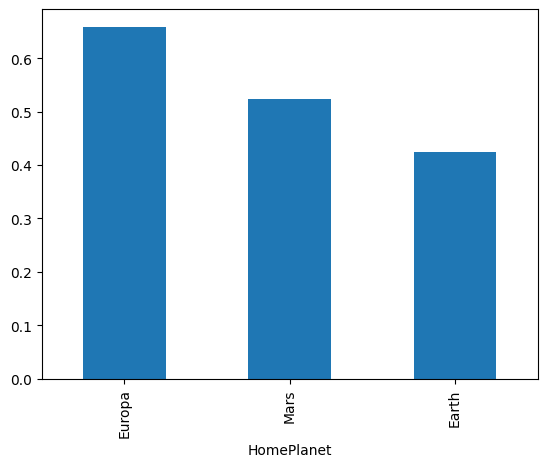

In [25]:
(
    X
    .groupby("HomePlanet")
    ["Transported"]
    .mean()
    .sort_values(ascending = False)
    .plot(kind = "bar")
);

In [26]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [27]:
_ = (
    X
    .groupby(["HomePlanet", "CryoSleep"])
    .agg(
        nr_rows = ("Cabin", len),
        transported_ratio = ("Transported", np.mean)
    )
    .assign(
        nr_rows_pct = lambda df: round((df["nr_rows"]/df["nr_rows"].sum())*100, 2),
        transported_ratio = lambda df: round(df["transported_ratio"] * 100, 2)
    )
);

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3907/3554285840.py:2: FutureWarning: The provided callable <function mean at 0x12079d5e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


In [28]:
_

nr_rows  transported_ratio  nr_rows_pct
HomePlanet CryoSleep                                         
Earth      False         3106              32.10        37.53
           True          1382              65.63        16.70
Europa     False         1162              40.02        14.04
           True           911              98.90        11.01
Mars       False         1047              27.70        12.65
           True           669              91.18         8.08

In [29]:
X["LenCabin"] = X["Cabin"].apply(lambda cabin: len(str(cabin)))

In [30]:
X.groupby(["LenCabin"]).size()

LenCabin
3     199
5     130
6    1201
7    5043
8    2120
dtype: int64

In [31]:
X[X["LenCabin"] == 5].head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,LenCabin
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,5
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,5
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,5


In [32]:
X["Cabin"].fillna("NA", inplace = True)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3907/3468940878.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Cabin"].fillna("NA", inplace = True)


In [33]:
X["CabinFirstLetter"] = X["Cabin"].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin)
X["CabinLastLetter"] = X["Cabin"].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin)

In [34]:
X["CabinFirstLetter"].value_counts().sort_index()

CabinFirstLetter
A      256
B      779
C      747
D      478
E      876
F     2794
G     2559
NA     199
T        5
Name: count, dtype: int64

In [35]:
X["CabinLastLetter"].value_counts().sort_index()

CabinLastLetter
NA     199
P     4206
S     4288
Name: count, dtype: int64

In [36]:
X["Cabin"].sample(10)

PassengerId
6642_01    G/1081/S
4726_05     C/187/S
8027_01    G/1297/S
1316_02      E/95/S
2625_01     G/426/P
5463_01    F/1045/S
4049_01      A/47/S
3613_01     F/748/P
5847_01    F/1115/S
3868_05     F/731/S
Name: Cabin, dtype: object

In [37]:
(
    X
    .groupby(["CabinFirstLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinFirstLetter
A     0.496094
B     0.734275
C     0.680054
D     0.433054
E     0.357306
F     0.439871
G     0.516217
NA    0.502513
T     0.200000
Name: Transported, dtype: float64

In [38]:
(
    X
    .groupby(["CabinLastLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinLastLetter
NA    0.502513
P     0.451260
S     0.555037
Name: Transported, dtype: float64

In [39]:
pd.concat([
    (
        X
        .groupby(["CabinFirstLetter", "CabinLastLetter"])
        ["Transported"]
        .mean()
        .sort_index()
        .unstack()
    ),
    (
        X
        .groupby(["CabinFirstLetter"])
        ["Transported"]
        .mean()
        .sort_index()
    )], axis = 1)

,NA,P,S,Transported
CabinFirstLetter,,,,
A,NaN,0.435897,0.546763,0.496094
B,NaN,0.674221,0.784038,0.734275
C,NaN,0.580645,0.763547,0.680054
D,NaN,0.403226,0.465217,0.433054
E,NaN,0.342657,0.371365,0.357306
F,NaN,0.410987,0.470501,0.439871
G,NaN,0.448276,0.583788,0.516217
NA,0.502513,NaN,NaN,0.502513
T,NaN,0.250000,0.000000,0.200000


In [40]:
X.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,LenCabin
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,6.984240
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.898869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,7.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


In [41]:
X.isnull().sum()

HomePlanet          201
CryoSleep           217
Cabin                 0
Destination         182
Age                 179
VIP                 203
RoomService         181
FoodCourt           183
ShoppingMall        208
Spa                 183
VRDeck              188
Name                200
Transported           0
LenCabin              0
CabinFirstLetter      0
CabinLastLetter       0
dtype: int64

In [42]:
X.shape

(8693, 16)

In [43]:
(
    X
    .pivot_table(
        index = "HomePlanet",
        columns = "Destination",
        values = "Transported",
        aggfunc = [len, np.mean],
        margins = True
    )
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3907/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x12079d5e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3907/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x12079d5e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3907/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x12079d5e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


len                                        mean  \
Destination 55 Cancri e PSO J318.5-22 TRAPPIST-1e   All 55 Cancri e   
HomePlanet                                                            
Earth               690           712        3101  4503    0.504348   
Europa              886            19        1189  2094    0.689616   
Mars                193            49        1475  1717    0.611399   
All                1769           780        5765  8314    0.608819   

                                                 
Destination PSO J318.5-22 TRAPPIST-1e       All  
HomePlanet                                       
Earth            0.498596    0.389229  0.424162  
Europa           0.736842    0.634987  0.659026  
Mars             0.448980    0.511864  0.521258  
All              0.501282    0.471292  0.503368

In [45]:
X["Name"].fillna("NA").apply(lambda name: len(name.split(" "))).value_counts()

Name
2    8493
1     200
Name: count, dtype: int64

In [46]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,LenCabin,CabinFirstLetter,CabinLastLetter
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,5,B,P
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,5,F,S
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5,A,S
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5,A,S
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,5,F,S


In [47]:
X["Surname"] = X["Name"].fillna("NA").apply(lambda name: name.split(" ")[1] if name != "NA" else name)

In [48]:
X["Surname"]

PassengerId
0001_01      Ofracculy
0002_01          Vines
0003_01         Susent
0003_02         Susent
0004_01    Santantines
              ...     
9276_01      Noxnuther
9278_01      Mondalley
9279_01         Connon
9280_01      Hontichre
9280_02      Hontichre
Name: Surname, Length: 8693, dtype: object

In [49]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
)

Surname
Acobson        0.250000
Acobsond       0.333333
Adavisons      0.444444
Adkinson       0.000000
Admingried     0.750000
                 ...   
Wynneyerson    0.500000
Yanton         0.285714
Yatters        0.500000
Yorkland       0.636364
Youngrayes     0.333333
Name: Transported, Length: 2218, dtype: float64

In [51]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
    .value_counts(normalize=True)
    .sort_index()
)

Transported
0.000000    0.165915
0.111111    0.000902
0.125000    0.002254
0.142857    0.002705
0.166667    0.009468
0.200000    0.019387
0.222222    0.000451
0.230769    0.000451
0.250000    0.037421
0.266667    0.000451
0.272727    0.001353
0.285714    0.010821
0.300000    0.001353
0.307692    0.000451
0.333333    0.076646
0.357143    0.000451
0.363636    0.001353
0.375000    0.009017
0.384615    0.000451
0.388889    0.000451
0.400000    0.033814
0.416667    0.000451
0.428571    0.015329
0.444444    0.003607
0.454545    0.003156
0.461538    0.000451
0.500000    0.168170
0.505000    0.000451
0.545455    0.001353
0.555556    0.004959
0.571429    0.012624
0.583333    0.001353
0.600000    0.034265
0.615385    0.000451
0.625000    0.004058
0.636364    0.003156
0.642857    0.000451
0.666667    0.080703
0.700000    0.000902
0.714286    0.009017
0.727273    0.000902
0.750000    0.040126
0.769231    0.000451
0.777778    0.001353
0.800000    0.021641
0.833333    0.009017
0.857143    0.002705
0

In [52]:
del X, _

# Preprocessing and Modelling

In [53]:
X_train, X_test = load_data()

In [54]:
y = X_train.pop("Transported")

In [55]:
class DebuggerTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print("DummyTransformer")
        return X

In [56]:
class CabinLetterExtractor(BaseEstimator, TransformerMixin):
    
    
    def __init__(self, letter:Union["first", "last"], verbose:bool=False):
        
        self.__assert_letter(letter=letter)
        
        self.letter = letter
        self.verbose = verbose
        
    def __assert_letter(self, letter):
        
        assert_message = "Valid letters are `first` or `last`."
        assert_message += f"You have passed {letter}"
        
        assert letter in ["first", "last"], assert_message
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        if self.verbose:
            print("CabinLetterExtractor")
            print(type(X))
            
        if self.letter == "first":
            return X.iloc[:, 0].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin).to_frame()
        else:
            return X.iloc[:, 0].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin).to_frame()

In [57]:
ct_impute = ColumnTransformer(
    transformers = [
        ("impute_numerical", SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.number)),
        ("impute_cabin", SimpleImputer(strategy="constant", fill_value="NA"), ["Cabin"]),
        (
            "impute_categorical",
            SimpleImputer(strategy="most_frequent"),
            ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name']
        )
    ],
    remainder = 'drop'
)

In [58]:
ct_impute

ColumnTransformer(transformers=[('impute_numerical', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x177f9a550>),
                                ('impute_cabin',
                                 SimpleImputer(fill_value='NA',
                                               strategy='constant'),
                                 ['Cabin']),
                                ('impute_categorical',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'Name'])])

In [59]:
Xt = ct_impute.fit_transform(X_train)

In [60]:
Xt.shape

(8693, 12)

In [61]:
Xt.head()

,impute_numerical__Age,impute_numerical__RoomService,impute_numerical__FoodCourt,impute_numerical__ShoppingMall,impute_numerical__Spa,impute_numerical__VRDeck,impute_cabin__Cabin,impute_categorical__HomePlanet,impute_categorical__CryoSleep,impute_categorical__Destination,impute_categorical__VIP,impute_categorical__Name
PassengerId,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,B/0/P,Europa,False,TRAPPIST-1e,False,Maham Ofracculy
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,F/0/S,Earth,False,TRAPPIST-1e,False,Juanna Vines
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,A/0/S,Europa,False,TRAPPIST-1e,True,Altark Susent
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,A/0/S,Europa,False,TRAPPIST-1e,False,Solam Susent
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,F/1/S,Earth,False,TRAPPIST-1e,False,Willy Santantines


In [62]:
class SurnameExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, verbose:bool=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.iloc[:, 0].apply(lambda name: name.split(" ")[1] if name != "NA" else name).to_frame()

TO DO: define an EmbeddingTransfomer compatible with scikit-learn

https://medium.com/@micahmelling/categorical-embeddings-in-scikit-learn-pipeline-c81071be5140

In [64]:
fu_age = FeatureUnion(
    transformer_list = [
        ("fe_age_12", Binarizer(threshold=12)),
        ("fe_age_18", Binarizer(threshold=18)),
        ("fe_age_pass", "passthrough")       
    ]
)

In [65]:
fu_cabin = FeatureUnion(
    transformer_list = [
        ("extract_first_letter", CabinLetterExtractor(letter="first")),
        ("extract_last_letter", CabinLetterExtractor(letter="last"))
    ]
)

In [66]:
fe_cabin = Pipeline(
    steps = [
        ("extract_letters_from_cabin", fu_cabin),
        ("ohe_first_letter", OneHotEncoder(sparse_output=False)),
    ]
)

In [67]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, list_surnames):
        self.list_surnames = list_surnames
        self.oe = OrdinalEncoder()
        
        
    def fit(self, X, y=None):
        
        self.oe.fit(self.list_surnames)
        
        return self
    
    def transform(self, X, y=None):
        Xt = self.oe.transform(X)
        return Xt

In [69]:
# We are getting all the surnames that exist in train and test
# because our CustomOrdinalEncoder can faill when doing CV
# or when predicting test
surnames_ = pd.concat([X_train[["Name"]], X_test[["Name"]]]).dropna()

In [70]:
SURNAMES = SurnameExtractor().fit_transform(surnames_).values

In [71]:
fe_surname = Pipeline(
    steps = [
        ("extract_surname", SurnameExtractor()),
        ("custom_ordinal_encoder", CustomOrdinalEncoder(list_surnames=SURNAMES))
    ]
)

In [73]:
ct_fe = ColumnTransformer(
    transformers = [
        ("fu_age", fu_age, ["impute_numerical__Age"]),
        ("pass", "passthrough", [1, 2, 3, 4, 5]),
        ("fe_cabin", fe_cabin, ["impute_cabin__Cabin"]),
        (
            "ohe",
            OneHotEncoder(sparse_output=False),
            ["impute_categorical__HomePlanet", "impute_categorical__CryoSleep", "impute_categorical__VIP"]
        ),
        ("oe", OrdinalEncoder(), ["impute_categorical__Destination"]),
        ("surname", fe_surname, ["impute_categorical__Name"])
    ],
    remainder = "passthrough"
)

In [74]:
ct_fe

ColumnTransformer(remainder='passthrough',
                  transformers=[('fu_age',
                                 FeatureUnion(transformer_list=[('fe_age_12',
                                                                 Binarizer(threshold=12)),
                                                                ('fe_age_18',
                                                                 Binarizer(threshold=18)),
                                                                ('fe_age_pass',
                                                                 'passthrough')]),
                                 ['impute_numerical__Age']),
                                ('pass', 'passthrough', [1, 2, 3, 4, 5]),
                                ('fe_cabin',
                                 Pipeline(steps=[('extract_letters_from_cabin',
                                                  FeatureUnion(transformer_...
                                  'impute_categorical__CryoSleep',
                                  'impute_categorical__VIP']),
                                ('oe', OrdinalEncoder(),
                                 ['impute_categorical__Destination']),
                                ('surname',
                                 Pipeline(steps=[('extract_surname',
                                                  SurnameExtractor()),
                                                 ('custom_ordinal_encoder',
                                                  CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                 ['impute_categorical__Name'])])

In [76]:
pipe = Pipeline(
    steps = [
        ("impute", ct_impute),
        ("fe", ct_fe),
        ("model",HistGradientBoostingClassifier())
    ]
)

In [77]:
pipe

Pipeline(steps=[('impute',
                 ColumnTransformer(transformers=[('impute_numerical',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x177f9a550>),
                                                 ('impute_cabin',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Cabin']),
                                                 ('impute_categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destinatio...
                                                 ('oe', OrdinalEncoder(),
                                                  ['impute_categorical__Destination']),
                                                 ('surname',
                                                  Pipeline(steps=[('extract_surname',
                                                                   SurnameExtractor()),
                                                                  ('custom_ordinal_encoder',
                                                                   CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                                  ['impute_categorical__Name'])])),
                ('model', HistGradientBoostingClassifier())])

In [78]:
X_train_ = pipe[:2].fit_transform(X_train)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_sklearn_benchmark/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


In [79]:
X_train_.head(3)

,fu_age__fe_age_12__impute_numerical__Age,fu_age__fe_age_18__impute_numerical__Age,fu_age__fe_age_pass__impute_numerical__Age,pass__impute_numerical__RoomService,pass__impute_numerical__FoodCourt,pass__impute_numerical__ShoppingMall,pass__impute_numerical__Spa,pass__impute_numerical__VRDeck,fe_cabin__impute_cabin__Cabin_A,fe_cabin__impute_cabin__Cabin_B,...,fe_cabin__impute_cabin__Cabin_S,ohe__impute_categorical__HomePlanet_Earth,ohe__impute_categorical__HomePlanet_Europa,ohe__impute_categorical__HomePlanet_Mars,ohe__impute_categorical__CryoSleep_False,ohe__impute_categorical__CryoSleep_True,ohe__impute_categorical__VIP_False,ohe__impute_categorical__VIP_True,oe__impute_categorical__Destination,surname__x0
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,1.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1551.0
0002_01,1.0,1.0,24.0,109.0,9.0,25.0,549.0,44.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2289.0
0003_01,1.0,1.0,58.0,43.0,3576.0,0.0,6715.0,49.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2153.0


In [80]:
y.value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [85]:
cv_scores = cross_val_score(estimator=pipe, X=X_train, y=y, cv=10)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_sklearn_benchmark/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_sklearn_benchmark/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_sklearn_benchmark/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_sklearn_benchmark/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature

In [86]:
# Benchmark -                     0.7234581961033293
# New Model con OHE -             0.7155214740155814
# New Model con 4 depth -         0.764529582159438
# Model with 4 depth y CabinFe -  0.7709713900242054
# HistGradient default params y - 0.7998441860772721
# HistGradient default params y - 0.8028344113328835  # Leaderboard - 1359
# default pipe + OE de Destionation

# HistGradient default params y - 0.8036411253521687  # Leaderboard - 1359 - 0.79331
# default pipe + OE de Destionation
# First and Last letter de Cabin

# HistGradient default params y - 0.8043334259222517 # Leaderboard -  1093 - 0.79682
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

In [87]:
def report_cv_scores(cv_scores):
    
    mean_cv_scores = np.mean(cv_scores)
    std_cv_scores = np.std(cv_scores)
    
    print(f"Mean scores: {mean_cv_scores}")
    print(f"Std scores: {std_cv_scores}")
    print(f"Scores: {cv_scores}")

In [88]:
report_cv_scores(cv_scores=cv_scores)

Mean scores: 0.8043334259222517
Std scores: 0.01915735464147169
Scores: [0.78390805 0.76781609 0.7908046  0.81933257 0.80207135 0.82508631
 0.82278481 0.82393556 0.81703107 0.79056387]


In [89]:
pipe.fit(X_train, y)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_sklearn_benchmark/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Pipeline(steps=[('impute',
                 ColumnTransformer(transformers=[('impute_numerical',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x177f9a550>),
                                                 ('impute_cabin',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Cabin']),
                                                 ('impute_categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destinatio...
                                                 ('oe', OrdinalEncoder(),
                                                  ['impute_categorical__Destination']),
                                                 ('surname',
                                                  Pipeline(steps=[('extract_surname',
                                                                   SurnameExtractor()),
                                                                  ('custom_ordinal_encoder',
                                                                   CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                                  ['impute_categorical__Name'])])),
                ('model', HistGradientBoostingClassifier())])

# Model Explainability

In [90]:
if isinstance(pipe[-1], DecisionTreeClassifier):
    
    fig = plt.figure(figsize = (15, 20))
    ax = fig.subplots()

    plot_tree(
        decision_tree = pipe[-1],
        feature_names = X_train_.columns,
        ax = ax,
        fontsize = 8
    )

    plt.tight_layout()

# Submission a Kaggle

In [91]:
y_pred = pipe.predict(X_test)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_sklearn_benchmark/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


In [92]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
timestamp

'2024_03_31_18_31_44'

In [93]:
X_test_copy = X_test.copy(deep = True)

In [94]:
X_test_copy["Transported"] = list(map(bool, y_pred))

In [96]:
if not KAGGLE:
    path_export = os.path.join(CWD, "outputs", f"submission_{timestamp}.csv")
else:
    path_export = f"submission_{timestamp}.csv"

In [97]:
(
    X_test_copy
    .reset_index()
    [["PassengerId", "Transported"]]
    .to_csv(path_export, index=False)
)

# The End